<a href="https://colab.research.google.com/github/talhaanwarch/my_pytorch/blob/master/coivd_tpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.researchgate.net/publication/351212635_COVID-CT-MD_COVID-19_computed_tomography_scan_dataset_applicable_in_machine_learning_and_deep_learning


In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [1]:
%%capture
#TPU
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
#file reading packages
!pip install SimpleITK
!pip install pydicom
!pip install pylibjpeg
!pip install gdcm
!pip install pylibjpeg-libjpeg
!pip install numpy --upgrade --ignore-installed
#pytorch stuff
!pip install pytorch-lightning
!pip install torchmetrics
!pip install albumentations==1.0.0

In [3]:
import albumentations
from albumentations.pytorch import ToTensorV2

albumentations.__version__

'1.0.0'

In [4]:
import numpy as np
assert np.__version__>='1.20.3', 'Numpy version should be 1.20.3'

In [5]:
import os
if (os.path.isfile('COVIDCTMD.zip')) or (os.path.isdir('data')) is False:
  !wget https://s3-eu-west-1.amazonaws.com/pstorage-npg-968563215/26069987/COVIDCTMD.zip

In [6]:
%%capture
if os.path.isdir('data') is False:
  !mkdir data
  !unzip /content/COVIDCTMD.zip -d data
  !rm /content/COVIDCTMD.zip

In [7]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import pydicom as dicom
from glob import glob
import cv2

In [8]:
!rm -rf /content/data/__MACOSX

In [9]:
clinical_features=pd.read_csv('/content/data/Clinical-data.csv')
clinical_features.head()

,clinical_data,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,Diagnosis,Folder,Patient Gender,Patient Age,Weight,Clinical characteristics,Surgery,Follow-up,PCR
1,0.0,COVID-19,P001,M,039Y,80,"Dyspnea, Cough, Fever",NaN,NaN,NaN
2,1.0,COVID-19,P002,F,048Y,75,"Dyspnea, Flu-like symptoms",No,Uneventful,NaN
3,2.0,COVID-19,P003,M,068Y,90,Cough,NaN,Hospitalized,NaN
4,3.0,COVID-19,P004,M,065Y,75,"Dyspnea, fever",No,Uneventful,NaN


In [10]:
df=pd.read_csv('/content/data/Index.csv')
df.head()

,Label Index,Diagnosis,Relative Path,Folder/ID
0,0,COVID-19,./COVID-19/,P001
1,1,COVID-19,./COVID-19/,P002
2,2,COVID-19,./COVID-19/,P003
3,3,COVID-19,./COVID-19/,P004
4,4,COVID-19,./COVID-19/,P005


In [11]:
df=pd.read_csv('/content/data/Radiogists-seperated-labels.csv')
df.head()

,ID,Radiologist #1,Radiologist #2,Radiologist #3
0,P001,COVID,COVID,COVID
1,P002,COVID,COVID,COVID
2,P003,COVID,COVID,COVID
3,P004,COVID,COVID,COVID
4,P005,COVID,COVID,COVID


2319 0
255 0


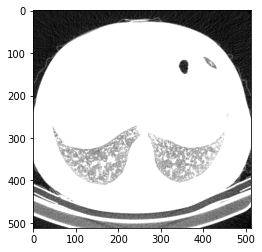

In [12]:
import pydicom as dicom
ds = dicom.dcmread('data/Normal Cases/normal074/IM0108.dcm')
x=np.array(ds.pixel_array)
print(x.max(),x.min())
x = cv2.convertScaleAbs(x)
print(x.max(),x.min())
plt.imshow(x,cmap='gray')

2319 0


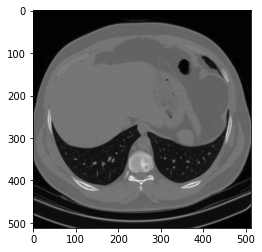

In [37]:
from PIL import Image
dcm_img = dicom.dcmread('data/Normal Cases/normal074/IM0108.dcm').pixel_array
#dcm_img = Image.fromarray(dcm_img)
print(np.max(dcm_img),np.min(dcm_img))
plt.imshow(dcm_img,cmap='gray')

max min  1.0 0.0
dtype float64


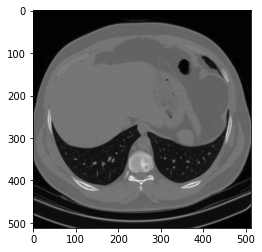

In [38]:
x=np.array(dcm_img)
x=(x-x.min())/(x.max()-x.min())
print('max min ',np.max(x),np.min(x))
print('dtype',x.dtype)
plt.imshow(x,cmap='gray')

In [15]:
# avg,stdd=[],[]
# for _ in range(len(train_df)//25):
#   x = dicom.dcmread(train_df.sample(1).image.values[0]).pixel_array
#   x= Image.fromarray(image)  

#   avg.append(np.mean(x))
#   stdd.append(np.std(x))
# m,s=np.mean(avg),np.mean(stdd)
# print(m,s)

In [16]:
'''
This code work for 2D slices of 3D.
It load it into the dataframe
'''

'\nThis code work for 2D slices of 3D.\nIt load it into the dataframe\n'

In [17]:
def flatten(path,label=None):
  '''
  flatten list to single list
  path: images path in a list
  label: corresponding label in list
  '''
  path = [item for sublist in path for item in sublist]
  label = [item for sublist in label for item in sublist]
  return path, label

In [18]:
def prepare_data(path='data',split=True,createDF=True):
  '''
  read data as dataframe 
  path: path of main directory in which classes are present
  split: split data to train and val
  convertDF: create dataframe or return list
  '''
  main_path=glob(path+'/*/')
  image_paths,image_labels=[],[]
  for class_folder in main_path: #iterate class folder
    for subject_folder in glob(class_folder+'*/'):#iterate subject folder
      subjects_paths,subject_labels=[],[]
      for img in glob(subject_folder+'/*.dcm'):#loop all images in subject folder
        subjects_paths.append(img)
        subject_labels.append(class_folder.split('/')[-2])
      image_paths.append(subjects_paths)
      image_labels.append(subject_labels)
  if split:
    train_path,val_path,train_label,val_label=train_test_split(image_paths,image_labels,test_size=0.2)
    train_path,train_label=flatten(train_path,train_label)
    val_path,val_label=flatten(val_path,val_label)
    if createDF:
      train_df=pd.DataFrame(zip(train_path,train_label),columns=['image','label'])
      val_df=pd.DataFrame(zip(val_path,val_label),columns=['image','label'])
      return train_df,val_df
    else:
      return train_path,val_path,train_label,val_label
  else:
    if createDF:
      image_paths,image_labels=flatten(image_paths,image_labels)
      df=pd.DataFrame(zip(image_paths,image_labels),columns=['image','label'])
      return 
    else:
      return image_paths,image_labels

In [19]:
train_df,val_df=prepare_data(split=True,createDF=True)

In [20]:
encode={k:v for v,k in enumerate(train_df.label.unique())}
decode={v:k for v,k in enumerate(train_df.label.unique())}

In [21]:
train_df.label=train_df.label.map(encode)
train_df.head()

,image,label
0,data/COVID-19 Cases/P120/IM0106.dcm,0
1,data/COVID-19 Cases/P120/IM0011.dcm,0
2,data/COVID-19 Cases/P120/IM0108.dcm,0
3,data/COVID-19 Cases/P120/IM0098.dcm,0
4,data/COVID-19 Cases/P120/IM0112.dcm,0


In [22]:
gdf=train_df.image.str.split('/',expand=True)
gdf.head()

,0,1,2,3
0,data,COVID-19 Cases,P120,IM0106.dcm
1,data,COVID-19 Cases,P120,IM0011.dcm
2,data,COVID-19 Cases,P120,IM0108.dcm
3,data,COVID-19 Cases,P120,IM0098.dcm
4,data,COVID-19 Cases,P120,IM0112.dcm


In [23]:
gdf.groupby(2).size()

2
P001         148
P002         133
P003         134
P004         164
P005         144
            ... 
normal070    176
normal071    145
normal072    152
normal075    159
normal076    171
Length: 244, dtype: int64

In [24]:
val_df.label=val_df.label.map(encode)
val_df.head()

,image,label
0,data/Normal Cases/normal032/IM0106.dcm,2
1,data/Normal Cases/normal032/IM0011.dcm,2
2,data/Normal Cases/normal032/IM0108.dcm,2
3,data/Normal Cases/normal032/IM0098.dcm,2
4,data/Normal Cases/normal032/IM0112.dcm,2


In [25]:
from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
from torch.nn.functional import cross_entropy
from sklearn.utils import class_weight
from torchvision import transforms 
import torchvision.models as models
import torchmetrics
import torch#pytorch
from sklearn.utils import class_weight


In [84]:


from albumentations import *

from albumentations.pytorch import ToTensorV2

def augmentation1():
    """albumentations image augmentation"""
    return Compose([
            Resize(224, 224),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(0.05,0.05,5), 
            OpticalDistortion(),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
aug=augmentation1()

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:645: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


In [85]:

from torch.utils.data import DataLoader, Dataset
class DataReader(Dataset):
  def __init__(self,df,transform=None):
    super(DataReader,self).__init__()
    self.df=df
    self.transform=transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self,index):
    image_path=self.df.image[index]
    image_label=self.df.label[index]

    #read data
    image = dicom.dcmread(image_path).pixel_array

    image=(x-x.min())/(x.max()-x.min())

    
    if self.transform:
      image=self.transform(image=image)['image']
    return image,image_label

torch.Size([1, 224, 224])


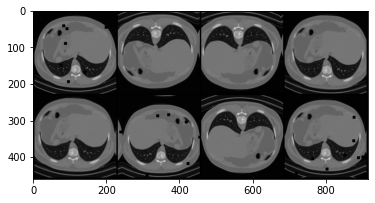

In [86]:
#testing above code
batch=next(iter(DataLoader(DataReader(train_df,aug), batch_size = 8, num_workers=1,shuffle=True)))
print(batch[0][0].shape)

from torch.utils.data.dataloader import DataLoader
import torchvision
import matplotlib.pyplot as plt
grid_img=torchvision.utils.make_grid(batch[0],4,4)
plt.imshow(grid_img.permute(1, 2, 0))

In [87]:
#@title
import torch
from torch import Tensor
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Optional


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-f37072fd.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-b627a593.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-0676ba61.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-63fe2227.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-394f9c45.pth',
    'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
}


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)


def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-34 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet34', BasicBlock, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)


def resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-101 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet101', Bottleneck, [3, 4, 23, 3], pretrained, progress,
                   **kwargs)


def resnet152(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNet-152 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet152', Bottleneck, [3, 8, 36, 3], pretrained, progress,
                   **kwargs)


def resnext50_32x4d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-50 32x4d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 4
    return _resnet('resnext50_32x4d', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def resnext101_32x8d(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""ResNeXt-101 32x8d model from
    `"Aggregated Residual Transformation for Deep Neural Networks" <https://arxiv.org/pdf/1611.05431.pdf>`_.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['groups'] = 32
    kwargs['width_per_group'] = 8
    return _resnet('resnext101_32x8d', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)


def wide_resnet50_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-50-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet50_2', Bottleneck, [3, 4, 6, 3],
                   pretrained, progress, **kwargs)


def wide_resnet101_2(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> ResNet:
    r"""Wide ResNet-101-2 model from
    `"Wide Residual Networks" <https://arxiv.org/pdf/1605.07146.pdf>`_.

    The model is the same as ResNet except for the bottleneck number of channels
    which is twice larger in every block. The number of channels in outer 1x1
    convolutions is the same, e.g. last block in ResNet-50 has 2048-512-2048
    channels, and in Wide ResNet-50-2 has 2048-1024-2048.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    kwargs['width_per_group'] = 64 * 2
    return _resnet('wide_resnet101_2', Bottleneck, [3, 4, 23, 3],
                   pretrained, progress, **kwargs)

In [88]:
x=torch.randn(3,1,224,224)
model=resnext50_32x4d()
model(x).shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([3, 1000])

In [89]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [90]:
class OurModel(LightningModule):
  def __init__(self):
    super(OurModel,self).__init__()
    #architecute
    self.model =resnext50_32x4d()
    self.fc1= nn.Linear(1000,500)
    self.fc2= nn.Linear(500,3)
    self.relu = nn.ReLU()
    
  #parameters
    self.lr=0.0001
    self.batch_size=96
    self.numworker=2
    self.train_acc = torchmetrics.Accuracy()
    self.val_acc = torchmetrics.Accuracy()
    self.test_acc = torchmetrics.Accuracy()
    self.class_weights =torch.tensor(class_weight.compute_class_weight('balanced',\
                  np.unique(train_df.label),train_df.label),dtype=torch.float32)
    self.criterion=FocalLoss()
  def forward(self,x):
    x= self.model(x)
    x= self.fc1(x)
    x= self.relu(x)
    x= self.fc2(x) 
    return x

 

  def configure_optimizers(self):
    return torch.optim.AdamW(params=self.parameters(),lr=self.lr )

  def train_dataloader(self):
    return DataLoader(DataReader(train_df,aug), batch_size = self.batch_size, num_workers=self.numworker,shuffle=True)

  def training_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)
    pred=torch.max(out,dim=1)[1]
    train_acc=self.train_acc(pred,label)
    self.log('train/acc', train_acc, on_epoch=True,prog_bar=True)
    self.log('train/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def val_dataloader(self):
    return DataLoader(DataReader(val_df,aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)
    
  def validation_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)
    pred=torch.max(out,dim=1)[1]
    valid_acc=self.val_acc(pred,label)
    self.log('val/acc', valid_acc, on_epoch=True,prog_bar=True)
    self.log('val/loss', loss, on_epoch=True,prog_bar=True)
    return loss

  def test_dataloader(self):
    return DataLoader(DataReader(val_df,aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)
    
  def test_step(self,batch,batch_idx):
    image,label=batch
    out=self(image)
    loss=self.criterion(out,label)
    pred=torch.max(out,dim=1)[1]
    test_acc=self.test_acc(pred,label)
    self.log('test/acc', test_acc, on_epoch=True,prog_bar=True)
    self.log('test/loss', loss, on_epoch=True,prog_bar=True)
    return loss

In [ ]:
checkpoint_callback = ModelCheckpoint(monitor='val/loss',dirpath='/content/drive/MyDrive/',
                                      filename='covidctmd' )
model = OurModel()
trainer = Trainer(max_epochs=6, auto_lr_find=False, auto_scale_batch_size=False,
                  tpu_cores=8,precision=16,
                  #gpus=-1,
                  progress_bar_refresh_rate=30, 
                  callbacks=[checkpoint_callback]
                  )
trainer.tune(model)
trainer.fit(model)

GPU available: False, used: False
TPU available: True, using: 8 TPU cores


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/chest_covidctmd.pt')

In [ ]:
trainer.test(model)

In [ ]:
test_loader=DataLoader(DataReader(val_df,aug), batch_size = 64,num_workers=1,  shuffle=False)
model.eval()
with torch.no_grad():
  preds,labels=[],[]
  for img, lab in test_loader:
    pred=model(img)

    preds.append(pred.detach().numpy())
    labels.append(lab)

In [ ]:
preds=np.concatenate(preds)
labels=np.concatenate(labels)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(labels,np.argmax(preds,1)))

In [ ]:
torch.save(model.model.state_dict(), '/content/drive/MyDrive/pre_chest_covidctmd.pt')